In [1]:
# make imports
import pandas as pd

import numpy as np

from tsfresh import select_features

import xgboost

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from feature_selection import FeatureSelector

import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: Qt5Agg


In [2]:
# all extracted features from tsfresh
# the extracted features are the same for all models
full_features = pd.read_pickle('/Users/Rohil/Documents/iGEM/yemen/exhaustive_extracted_features.pkl')

In [3]:
# test values for different time frames (in a nice format)
y_df = pd.read_pickle('/Users/Rohil/Documents/iGEM/yemen/y_df_for_feature_selection.pkl')

In [4]:
full_features.head()

,fatalities__abs_energy_week_1,fatalities__absolute_sum_of_changes_week_1,"fatalities__agg_autocorrelation__f_agg_""mean""_week_1","fatalities__agg_autocorrelation__f_agg_""median""_week_1","fatalities__agg_autocorrelation__f_agg_""var""_week_1","fatalities__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""_week_1","fatalities__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""_week_1","fatalities__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""_week_1","fatalities__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""_week_1","fatalities__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""_week_1",...,new_deaths__value_count__value_-inf_week_6,new_deaths__value_count__value_0_week_6,new_deaths__value_count__value_1_week_6,new_deaths__value_count__value_inf_week_6,new_deaths__value_count__value_nan_week_6,new_deaths__variance_week_6,new_deaths__variance_larger_than_standard_deviation_week_6,days_from,gov_iso,date
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,YE-AB,2017-05-23
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,YE-AD,2017-05-23
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,YE-AM,2017-05-23
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,YE-BA,2017-05-23
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,YE-DA,2017-05-23


In [5]:
y_df.head()

,gov_iso,date,week_1_cases,week_2_cases,week_2_to_4_cases,week_4_to_6_cases,week_6_to_8_cases
0,YE-AB,2017-05-23,6.976066,7.594340,18.482427,51.257999,65.009775
1,YE-AD,2017-05-23,5.711380,16.454390,21.250650,28.290273,24.346000
2,YE-AM,2017-05-23,24.813754,32.088848,76.218802,92.430835,68.766904
3,YE-BA,2017-05-23,17.116538,11.683058,23.629375,29.137843,28.826720
4,YE-DA,2017-05-23,14.377386,14.077581,66.073362,85.859416,127.428383


In [6]:
# ignoring anything that happens before June, as there's not enough data for feature calculation
full_features = full_features[full_features.date>'2017-06-01']
y_df = y_df[y_df.date>'2017-06-01']

In [7]:
# splitting ys by time frame
y1 = y_df[['date', 'gov_iso', 'week_1_cases']]
y2 = y_df[['date', 'gov_iso', 'week_2_cases']]
y2_4 = y_df[['date', 'gov_iso', 'week_2_to_4_cases']]
y4_6 = y_df[['date', 'gov_iso', 'week_4_to_6_cases']]
y6_8 = y_df[['date', 'gov_iso', 'week_6_to_8_cases']]

In [8]:
# merging so that rows with same data and governorate are lined up properly
full_data_1 = y1.dropna().merge(full_features, how = 'left', on = ['gov_iso', 'date']).sort_values('date')
full_data_2 = y2.dropna().merge(full_features, how = 'left', on = ['gov_iso', 'date']).sort_values('date')
full_data_2_4 = y2_4.dropna().merge(full_features, how = 'left', on = ['gov_iso', 'date']).sort_values('date')
full_data_4_6 = y4_6.dropna().merge(full_features, how = 'left', on = ['gov_iso', 'date']).sort_values('date')
full_data_6_8 = y6_8.dropna().merge(full_features, how = 'left', on = ['gov_iso', 'date']).sort_values('date')

In [9]:
# performing feature selection using tsfresh's scalable hypothesis tests

In [10]:
selected_features_1 = select_features(full_data_1[full_features.columns].drop(columns=['date', 'gov_iso', 'days_from']), full_data_1['week_1_cases'], fdr_level=0.01)
selected_features_1.shape

(5355, 12192)

In [11]:
selected_features_2 = select_features(full_data_2[full_features.columns].drop(columns=['date', 'gov_iso', 'days_from']), full_data_2['week_2_cases'], fdr_level=0.01)
selected_features_2.shape

(5208, 12190)

In [12]:
selected_features_2_4 = select_features(full_data_2_4[full_features.columns].drop(columns=['date', 'gov_iso', 'days_from']), full_data_2_4['week_2_to_4_cases'], fdr_level=0.01)
selected_features_2_4.shape

(4914, 12151)

In [13]:
selected_features_4_6 = select_features(full_data_4_6[full_features.columns].drop(columns=['date', 'gov_iso', 'days_from']), full_data_4_6['week_4_to_6_cases'], fdr_level=0.01)
selected_features_4_6.shape

(4620, 12082)

In [14]:
selected_features_6_8 = select_features(full_data_6_8[full_features.columns].drop(columns=['date', 'gov_iso', 'days_from']), full_data_6_8['week_6_to_8_cases'], fdr_level=0.01)
selected_features_6_8.shape

(4326, 12008)

In [15]:
selected_features_1 = pd.concat([full_data_1.date, selected_features_1], axis=1)
selected_features_2 = pd.concat([full_data_2.date, selected_features_2], axis=1)
selected_features_2_4 = pd.concat([full_data_2_4.date, selected_features_2_4], axis=1)
selected_features_4_6 = pd.concat([full_data_4_6.date, selected_features_4_6], axis=1)
selected_features_6_8 = pd.concat([full_data_6_8.date, selected_features_6_8], axis=1)

In [16]:
def scale_features(scaler, X):

    X_scaled = pd.DataFrame(data=scaler.transform(X), columns = X.columns)
    
    return (X_scaled)

In [17]:
def train_cv_test_split(data, cv_split_date='2017-09-04', test_split_date='2017-10-02'):
    
    data_train, data_cv, data_test = data[(data.date<cv_split_date)].drop('date', axis=1), data[(data.date<test_split_date) & (data.date>=cv_split_date)].drop('date', axis=1), data[(data.date>=test_split_date)].drop('date', axis=1)
    
    return (data_train, data_cv, data_test)

In [21]:
def validate_performance(X, y):
    
    y = y.dropna()
    X = X.loc[y.index]
        
    X_train, X_cv, X_test = train_cv_test_split(X)
    y_train, y_cv, y_test = train_cv_test_split(y)

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train, X_cv, X_test = scale_features(scaler, X_train), scale_features(scaler, X_cv), scale_features(scaler, X_test)
    
    eval_set = [(X_train, y_train), (X_cv, y_cv)]
    
    model = xgboost.XGBRegressor( n_estimators = 400,
                                  learning_rate= 0.01, 
                                  max_depth= 6, 
                                  min_child_weight= 5,
                                  subsample= 0.6,
                                  colsample_bytree= 0.6,
                                  n_jobs = -1)
    
    model.fit(X_train, y_train, eval_metric='mae', eval_set=eval_set, early_stopping_rounds=15, verbose = 0)
    
    preds = model.predict(X_cv)
    
    ev = explained_variance_score(y_cv, preds)
    mae = mean_absolute_error(y_cv, preds)

    print ('Model with %s rounds (best) achieved %s explained variance and %s mean absolute error' % (str(model.best_iteration), str(ev), str(mae)))
    
    results = model.evals_result()
    
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)
    
    # plot mae
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax.plot(x_axis, results['validation_1']['mae'], label='CV')
    
    ax.legend()
    
    plt.ylabel('Mean Absolute Error')
    plt.title('XGBoost MAE')
    plt.show()
    

Model with 225 rounds (best) achieved 0.713727318346937 explained variance and 3.1858383852671186 mean absolute error


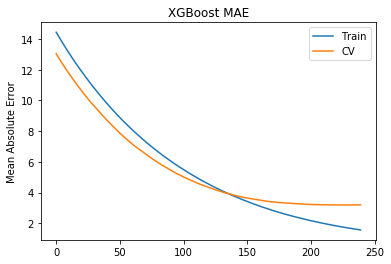

In [79]:
validate_performance(selected_features_1, full_data_1[['date', 'week_1_cases']])

Model with 191 rounds (best) achieved 0.5107158474661957 explained variance and 3.516979872963526 mean absolute error


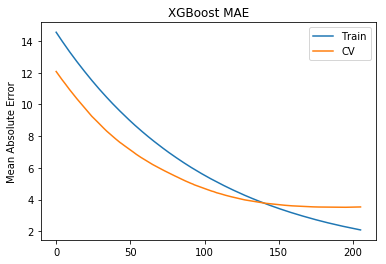

In [80]:
validate_performance(selected_features_2, full_data_2[['date', 'week_2_cases']])

Model with 144 rounds (best) achieved 0.7255942485069403 explained variance and 6.024705130581101 mean absolute error


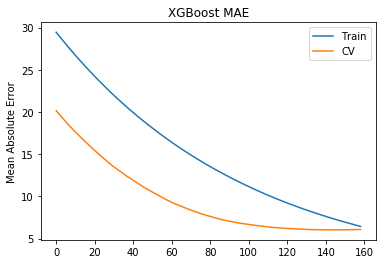

In [78]:
validate_performance(selected_features_2_4, full_data_2_4[['date', 'week_2_to_4_cases']])

Model with 117 rounds (best) achieved 0.6907516601203205 explained variance and 5.66591864546054 mean absolute error


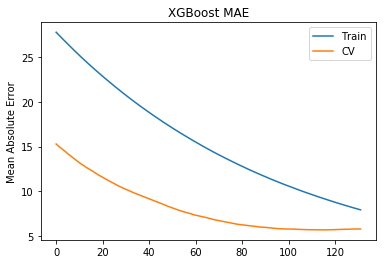

In [76]:
validate_performance(selected_features_4_6, full_data_4_6[['date', 'week_4_to_6_cases']])

Model with 128 rounds (best) achieved 0.6843810801997003 explained variance and 5.234277214064584 mean absolute error


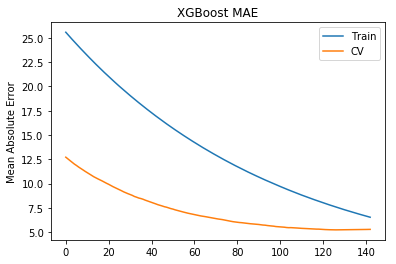

In [77]:
validate_performance(selected_features_6_8, full_data_6_8[['date', 'week_6_to_8_cases']])

In [19]:
fs = FeatureSelector(data = selected_features_4_6.drop(columns='date'), labels = full_data_4_6['week_4_to_6_cases'])

In [43]:
fs.identify_collinear(correlation_threshold=0.975)

3622 features with a correlation magnitude greater than 0.97.



In [46]:
cols_to_keep = set(selected_features_4_6.columns) - set(fs.ops['collinear'])

In [47]:
len(cols_to_keep)

8461

In [39]:
corr_selected_features_4_6_96 = corr_selected_features_4_6

In [48]:
corr_selected_features_4_6 = selected_features_4_6[list(cols_to_keep)]

Model with 105 rounds (best) achieved 0.698943834534691 explained variance and 5.66356812664857 mean absolute error


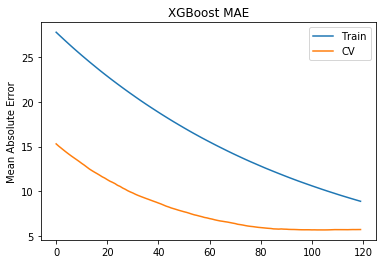

In [49]:
validate_performance(corr_selected_features_4_6, full_data_4_6[['date', 'week_4_to_6_cases']])

In [61]:
def recursive_feature_elimination(X, y):
    
    X_train, X_cv, X_test = train_cv_test_split(X)
    y_train, y_cv, y_test = train_cv_test_split(y)

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train, X_cv, X_test = scale_features(scaler, X_train), scale_features(scaler, X_cv), scale_features(scaler, X_test)
    
    eval_set = [(X_cv, y_cv)]

    model = xgboost.XGBRegressor( n_estimators = 125,
                                  learning_rate= 0.01, 
                                  max_depth= 6, 
                                  min_child_weight= 5,
                                  subsample= 0.6,
                                  colsample_bytree= 0.6,
                                  n_jobs = -1,
                                  eval_metric='mae', eval_set=eval_set, early_stopping_rounds=15, verbose = True)
    
    rfe = RFE(estimator=model, step=0.50, n_features_to_select=400, verbose = True)
    
    X_transformed = rfe.fit_transform(X_train, y_train)
    
    preds = rfe.estimator_.predict(rfe.transform(X_cv))
    
    print ("Explained variance of best estimator on cv set: " + str(explained_variance_score(y_cv, preds)))
    print ("Mae of best estimator on cv set: " + str(mean_absolute_error(y_cv, preds)))
    
    return (rfe, X_transformed)

In [62]:
rfe_4_6, corr_selected_features_4_6 = recursive_feature_elimination(corr_selected_features_4_6, full_data_4_6[['date', 'week_4_to_6_cases']])

C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 8460 features.


KeyboardInterrupt: 

In [ ]:
def recursive_feature_elimination_cv(X, y, step):
    
    X_train, X_cv, X_test = train_cv_test_split(X)
    y_train, y_cv, y_test = train_cv_test_split(y)

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train, X_cv, X_test = scale_features(scaler, X_train), scale_features(scaler, X_cv), scale_features(scaler, X_test)
    
    eval_set = [(X_cv, y_cv)]

    model = xgboost.XGBRegressor( n_estimators = 400,
                                  learning_rate= 0.01, 
                                  max_depth= 6, 
                                  min_child_weight= 5,
                                  subsample= 0.6,
                                  colsample_bytree= 0.6,
                                  n_jobs = -1)
    
    rfecv = RFECV(estimator=rfe_model, step=0.01 cv=eval_set,
              scoring='neg_mean_absolute_error', verbose = 3)
    
    rfecv.fit(X_train, y_train, eval_metric='mae', eval_set=eval_set, early_stopping_rounds=15, verbose = 0)
    
    return (rfecv)

In [52]:
def get_feature_importances(X, y, param_grid):

    y = y.dropna().drop('date', axis=1)
    X = X.loc[y.index].drop('date', axis=1)    

    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    tscv = TimeSeriesSplit(n_splits=3, max_train_size = 1500)

    model = xgboost.XGBRegressor(tree_method = 'gpu_hist', objective= 'gpu:reg:linear', gpu_id = 0)

    grid_search = GridSearchCV(model,
                        param_grid = param_grid,
                        cv = tscv.split(X_scaled),
                        scoring = 'explained_variance',
                        verbose=True)


    grid_search.fit(X_scaled, y)

    print (grid_search.best_params_)

    return(grid_search.best_estimator_, grid_search.cv_results_)

In [62]:
all_feature_param_grid = {'learning_rate': [0.001, 0.01], 
              'max_depth': [2,4,6],
              'min_child_weight': [3,5,7],
              'subsample': [0.4, 0.6],
              'colsample_bytree': [0.4, 0.6],
              'n_estimators': [150, 300]
}

In [54]:
all_feature_param_grid_done = {'learning_rate': [0.1], 
              'max_depth': [12],
              'min_child_weight': [45],
              'subsample': [0.5],
              'colsample_bytree': [0.5],
              'n_estimators': [300],
}

In [58]:
# all_feature_params = { 'objective':'reg:linear',
#               'learning_rate': 0.01, #so called `eta` value
#               'max_depth': 10,
#               'min_child_weight':40,
#               'subsample':.6,
#               'colsample_bytree':.6,
#               'n_estimators':500}

In [47]:
week1_xgb_full_features, week1_xgb_cv_results = get_feature_importances(selected_features_1, full_data_1[['date', 'week_1_cases']], all_feature_param_grid_done)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [56]:
week2_xgb_full_features, week2_xgb_cv_results = get_feature_importances(selected_features_2, full_data_2[['date', 'week_2_cases']], all_feature_param_grid)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [87]:
week2_4_xgb_full_features, week2_4_xgb_cv_results = get_feature_importances(selected_features_2_4, full_data_2_4[['date', 'week_2_to_4_cases']], all_feature_param_grid)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 180.9min finished


{'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 50, 'n_estimators': 300, 'subsample': 0.5}


In [63]:
week4_6_xgb_full_features, week4_6_xgb_cv_results = get_feature_importances(selected_features_4_6, full_data_4_6[['date', 'week_4_to_6_cases']], all_feature_param_grid)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 459.7min finished


{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.4}


In [65]:
pd.DataFrame(week4_6_xgb_cv_results)

C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,18.047515,1.616580,0.267216,0.002792,0.4,0.001,2,3,150,0.4,...,0.154820,0.150928,0.170020,0.024300,141,0.186214,0.189393,0.199459,0.191689,0.005645
1,18.587359,1.057784,0.270236,0.002655,0.4,0.001,2,3,150,0.6,...,0.145721,0.156206,0.170285,0.027658,137,0.187798,0.191537,0.200866,0.193400,0.005496
2,31.147802,2.034551,0.270858,0.000594,0.4,0.001,2,3,300,0.4,...,0.264408,0.266275,0.291553,0.037076,99,0.331772,0.335113,0.354420,0.340435,0.009983
3,31.279783,2.084298,0.273065,0.003620,0.4,0.001,2,3,300,0.6,...,0.249348,0.274123,0.291107,0.042751,101,0.333402,0.337786,0.356796,0.342661,0.010154
4,19.026325,1.132275,0.266364,0.000800,0.4,0.001,2,5,150,0.4,...,0.154820,0.150928,0.170063,0.024361,139,0.186274,0.189393,0.199459,0.191709,0.005626
5,18.913591,1.091152,0.269063,0.002708,0.4,0.001,2,5,150,0.6,...,0.145721,0.156206,0.170285,0.027658,137,0.187798,0.191537,0.200866,0.193400,0.005496
6,31.398578,2.214502,0.270582,0.000489,0.4,0.001,2,5,300,0.4,...,0.264408,0.266275,0.291645,0.037207,98,0.331856,0.335113,0.354420,0.340463,0.009958
7,31.273631,2.076970,0.273259,0.003560,0.4,0.001,2,5,300,0.6,...,0.249348,0.274123,0.291107,0.042751,101,0.333402,0.337786,0.356796,0.342661,0.010154
8,18.738720,1.095141,0.265742,0.001083,0.4,0.001,2,7,150,0.4,...,0.154820,0.150928,0.170063,0.024361,139,0.186274,0.189393,0.199459,0.191709,0.005626
9,18.882265,1.131046,0.265634,0.000948,0.4,0.001,2,7,150,0.6,...,0.145721,0.156206,0.170321,0.027708,133,0.187886,0.191537,0.200866,0.193430,0.005465


In [64]:
week6_8_xgb_full_features, week6_8_xgb_cv_results = get_feature_importances(selected_features_6_8, full_data_6_8[['date', 'week_6_to_8_cases']], all_feature_param_grid)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


KeyboardInterrupt: 

In [96]:
pd.DataFrame(week2_4_xgb_cv_results).to_csv('/Users/Rohil/Documents/iGEM/yemen/feature_engineering/tsfresh_feature_importances/week2_4_all_feature_cv_results.csv', index = False)

C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\util

In [66]:
pd.DataFrame(week4_6_xgb_cv_results).to_csv('/Users/Rohil/Documents/iGEM/yemen/feature_engineering/tsfresh_feature_importances/week4_6_all_feature_cv_results_2.csv', index = False)

C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\util

In [97]:
pd.DataFrame(week6_8_xgb_cv_results).to_csv('/Users/Rohil/Documents/iGEM/yemen/feature_engineering/tsfresh_feature_importances/week6_8_all_feature_cv_results.csv', index = False)

C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Rohil\Anaconda3\lib\site-packages\sklearn\util

In [552]:
model_dict = {'week1_xgb' : week1_xgb_full_features, 'week2_xgb' : week2_xgb_full_features, 'week2_to_4_xgb' : week2_4_xgb_full_features, 'week4_to_6_xgb' : week4_6_xgb_full_features, 'week6_to_8_xgb' : week6_8_xgb_full_features}

In [534]:
week6_8_xgb_full_features

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=10, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

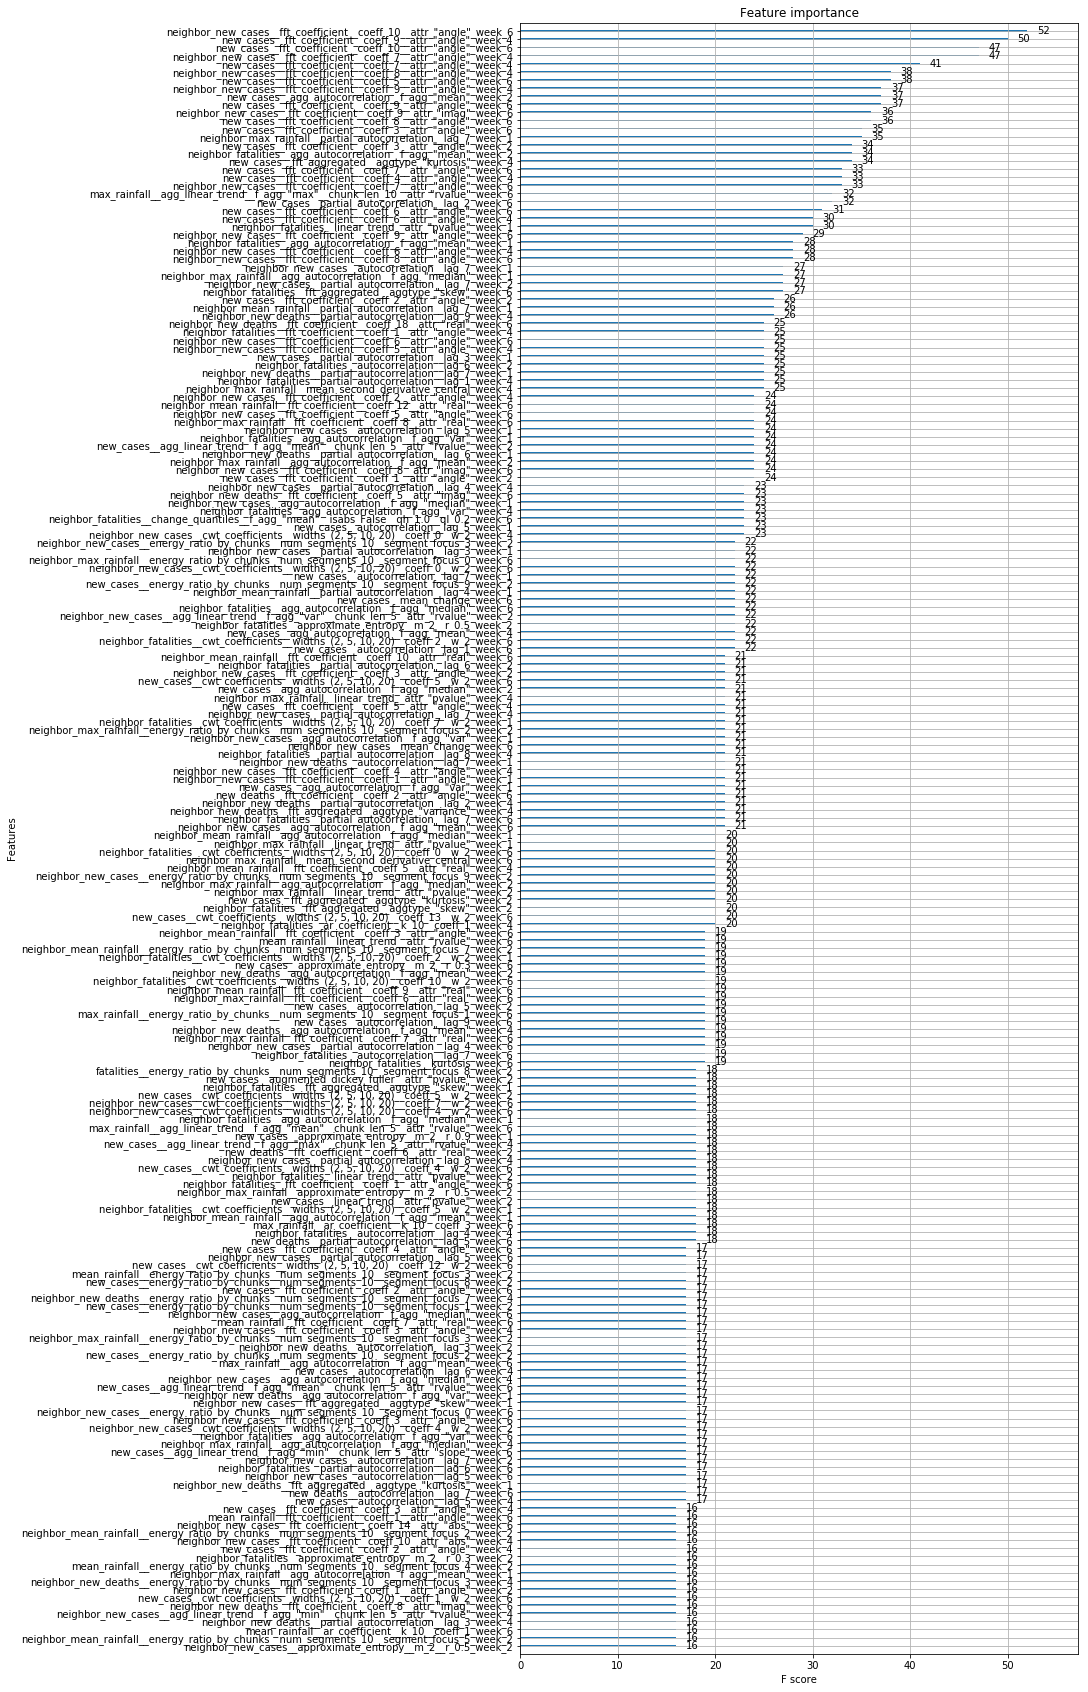

In [537]:
fig1, ax1 = plt.subplots(1,1, figsize = (10, 30))
xgboost.plot_importance(week6_8_xgb_full_features, ax=ax1, max_num_features = 200)

In [553]:
for key, val in model_dict.items():
    fig, ax = plt.subplots(1,1, figsize = (10, 40))
    xgboost.plot_importance(val, ax=ax, max_num_features = 300)
    fig.tight_layout()
    fig.savefig('/Users/Rohil/Documents/iGEM/yemen/feature_engineering/tsfresh_feature_importances/fdr_lvl 0.001/' + key + '.png')
    plt.clf()
    plt.close('all')

In [465]:
def get_feature_importances_pt2(X, y, xgb_all_features, model_params):
    
    scaler = StandardScaler()
        
    top300 = pd.Series(xgb_all_features.feature_importances_, X.drop('date', axis=1).columns).sort_values(ascending = False).head(300).index
    
    selection_model = xgboost.XGBRegressor(**model_params)

    select_X = X[top300]
    
    select_X_scaled = pd.DataFrame(scaler.fit_transform(select_X), columns = select_X.columns)

    selection_model.fit(select_X_scaled, y.drop('date', axis=1))

    return (selection_model)

In [466]:
week1_xgb_top300_features = get_feature_importances_pt2(selected_features_1, full_data_1[['date', 'week_1_cases']], week1_xgb_full_features, all_feature_params)
week2_xgb_top300_features = get_feature_importances_pt2(selected_features_2, full_data_2[['date', 'week_2_cases']], week2_xgb_full_features, all_feature_params)
week2_4_xgb_top300_features = get_feature_importances_pt2(selected_features_2_4, full_data_2_4[['date', 'week_2_to_4_cases']], week2_4_xgb_full_features, all_feature_params)
week4_6_xgb_top300_features = get_feature_importances_pt2(selected_features_4_6, full_data_4_6[['date', 'week_4_to_6_cases']], week4_6_xgb_full_features, all_feature_params)
week6_8_xgb_top300_features = get_feature_importances_pt2(selected_features_6_8, full_data_6_8[['date', 'week_6_to_8_cases']], week6_8_xgb_full_features, all_feature_params)

In [467]:
model_dict_top300_features = {'week1_xgb' : week1_xgb_top300_features, 'week2_xgb' : week2_xgb_top300_features, 'week2_to_4_xgb' : week2_4_xgb_top300_features, 'week4_to_6_xgb' : week4_6_xgb_top300_features, 'week6_to_8_xgb' : week6_8_xgb_top300_features}

In [468]:
for key, val in model_dict_top300_features.items():
    fig, ax = plt.subplots(1,1, figsize = (10, 40))
    xgboost.plot_importance(val, ax=ax, max_num_features = 300)
    fig.tight_layout()
    fig.savefig('/Users/Rohil/Documents/iGEM/yemen/feature_engineering/tsfresh_feature_importances/reranked top300 (fdr_lvl 0.001)/' + key + '.png')
    plt.clf()
    plt.close('all')

In [472]:
# there was no significant difference in the re-ranking, so not worrying about that anymore

In [483]:
def nfeature_search(X, y, xgb_all_features, max_training_size):
    
    thresholds = sorted(xgb_all_features.feature_importances_, reverse = True)
    
    nfeature_df = pd.DataFrame()

    # some of the ending values are undefined purposely, as there isnt't enough data to get cholera cases for x weeks
    y = y.dropna().drop('date', axis=1)
    X = X.loc[y.index].drop('date', axis=1)
        
    #X_train, X_test = X[(X.date<split_date)].drop('date', axis=1), X[(X.date>=split_date)].drop('date', axis=1)
    #y_train, y_test = y[(y.date<split_date)].drop('date', axis=1), y[(y.date>=split_date)].drop('date', axis=1)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    #X_train, X_test = scale_features(scaler, X_train), scale_features(scaler, X_test)
    
    tscv = TimeSeriesSplit(n_splits=3, max_train_size = max_training_size)
    
    for thresh in thresholds[0:100]:
        # select features using threshold
        selection = SelectFromModel(xgb_all_features, threshold=thresh, prefit=True)
        
        ev_list = []
        mae_list = []
        
        for train_index, test_index in tscv.split(X):

            #To get the indices 
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            select_X_train = selection.transform(X_train)
        
            selection_model = xgboost.XGBRegressor()

            selection_model.fit(select_X_train, y_train)

            # eval model
            select_X_test = selection.transform(X_test)
            y_pred = selection_model.predict(select_X_test)
            score = explained_variance_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            ev_list.append(score)
            mae_list.append(mae)

        print('Thresh=%s, n=%s, explained variance: %s, mean abs error: %s' % (thresh, select_X_train.shape[1], np.mean(ev_list), np.mean(mae_list)))
        print('explained variance for each split: ' + str(ev_list) + ', mae for each split: ' + str(mae_list))
        nfeature_df = nfeature_df.append(pd.Series({'threshold':thresh, 'n_features':select_X_train.shape[1], 'explained_variances':ev_list, 'mean_abs_errors': mae_list, 'mean_explained_variance':np.mean(ev_list), 'mean_mae': np.mean(mae_list)}), ignore_index = True)
    
    return (nfeature_df)  
   

In [484]:
# all_feature_params_v2 = {'nthread':4, #when use hyperthread, xgboost may become slower
#               'objective':'reg:linear',
#               'learning_rate': 0.01, #so called `eta` value
#               'max_depth': 12,
#               'min_child_weight': 40,
#               'silent':1,
#               'subsample':.4,
#               'colsample_bytree':.4,
#               'n_estimators':500}

In [485]:
# all_feature_params_v3 = {
#               'learning_rate': 0.1, #so called `eta` value
#               'max_depth': 8,
#               'min_child_weight':5,
#               'subsample':.7,
#               'colsample_bytree':.7,
#               'n_estimators':300}

In [554]:
feature_search_params = {
              'learning_rate': 0.1, #so called `eta` value
              'max_depth': 7,
              'min_child_weight':7,
              'subsample':.7,
              'colsample_bytree':.7,
              'n_estimators':250 
}

In [486]:
week1_nfeature_search = nfeature_search(selected_features_1, full_data_1[['date', 'week_1_cases']], week1_xgb_full_features, 500)

Thresh=0.007964486, n=1, explained variance: 0.6681923394840362, mean abs error: 2.194252280811377
explained variance for each split: [0.608763281483014, 0.6870541946258941, 0.7087595423432007], mae for each split: [3.659079365224065, 2.058542931948528, 0.8651345452615372]
Thresh=0.0059189624, n=2, explained variance: 0.699774322714604, mean abs error: 1.9070041614543065
explained variance for each split: [0.6994467141552781, 0.8194284340081521, 0.5804478199803815], mae for each split: [3.3127319909531394, 1.470586449909126, 0.937694043500654]
Thresh=0.0057013533, n=3, explained variance: 0.7472128662753234, mean abs error: 1.8023440593596842
explained variance for each split: [0.6950810971272854, 0.8563915287421398, 0.6901659729565452], mae for each split: [3.255742978217624, 1.3768078421696845, 0.7744813576917445]
Thresh=0.0053096577, n=4, explained variance: 0.7666194506675575, mean abs error: 1.7643045742057024
explained variance for each split: [0.7043600860481143, 0.8751822197105

explained variance for each split: [0.7202773942867498, 0.8956015317017736, 0.7467707088839806], mae for each split: [3.255362349044774, 1.3811815834137215, 0.7973705497046513]
Thresh=0.0013491752, n=60, explained variance: 0.7875498782908347, mean abs error: 1.8113048273877157
explained variance for each split: [0.7202773942867498, 0.8956015317017736, 0.7467707088839806], mae for each split: [3.255362349044774, 1.3811815834137215, 0.7973705497046513]
Thresh=0.0013056535, n=63, explained variance: 0.7812292683496457, mean abs error: 1.868137747505427
explained variance for each split: [0.7185376128073603, 0.8857891391141062, 0.7393610531274706], mae for each split: [3.3545828547099514, 1.4413408131283947, 0.8084895746779345]
Thresh=0.0013056535, n=63, explained variance: 0.7812292683496457, mean abs error: 1.868137747505427
explained variance for each split: [0.7185376128073603, 0.8857891391141062, 0.7393610531274706], mae for each split: [3.3545828547099514, 1.4413408131283947, 0.8084

KeyboardInterrupt: 

In [ ]:
week2_nfeature_search = nfeature_search(selected_features_2, full_data_2[['date', 'week_2_cases']], week2_xgb_top300_features, 500)

In [579]:
week2_4_nfeature_search = nfeature_search(selected_features_2_4, full_data_2_4[['date', 'week_2_to_4_cases']], week2_4_xgb_full_features, 1000)

Thresh=0.0021742368, n=1, explained variance: -0.09800813094437033, mean abs error: 14.025086851349068
explained variance for each split: [-0.06746593406017531, -0.14592636008869264, -0.08063209868424304], mae for each split: [18.42905704855494, 16.487581629767877, 7.158621875724384]
Thresh=0.0020551006, n=2, explained variance: -0.10966262750690015, mean abs error: 13.546004866746827
explained variance for each split: [-0.10249397833888652, -0.1392517329128542, -0.08724217126895972], mae for each split: [18.525756122059047, 16.195815460603484, 5.916443017577948]
Thresh=0.0019955323, n=3, explained variance: -0.12640553812984426, mean abs error: 13.618561679091924
explained variance for each split: [-0.10412206604941687, -0.20234342096857194, -0.07275112737154399], mae for each split: [18.54381616366812, 16.452913469632588, 5.858955403975067]
Thresh=0.0019061802, n=4, explained variance: -0.1245986275948574, mean abs error: 13.674798477263396
explained variance for each split: [-0.1222

KeyboardInterrupt: 

In [555]:
week4_6_nfeature_search = nfeature_search(selected_features_4_6, full_data_4_6[['date', 'week_4_to_6_cases']], week4_6_xgb_full_features, 1000)

Thresh=0.018384207, n=1, explained variance: -0.13107604717247612, mean abs error: 12.89366734037869
explained variance for each split: [-0.07655953589627806, -0.24447216126270188, -0.07219644435844841], mae for each split: [17.49413548376318, 15.563150844507744, 5.623715692865143]
Thresh=0.0019866296, n=2, explained variance: -0.16936837689145512, mean abs error: 13.12614210726815
explained variance for each split: [-0.0805343424448326, -0.2555137631907689, -0.17205702503876386], mae for each split: [17.486623818902213, 15.681711983107284, 6.210090519794952]
Thresh=0.0017658931, n=4, explained variance: -0.15139512679913047, mean abs error: 13.202887108861551
explained variance for each split: [-0.043336677396312195, -0.25971870157379695, -0.15113000142728228], mae for each split: [17.620084570179813, 15.778740576002205, 6.209836180402633]
Thresh=0.0017658931, n=4, explained variance: -0.15139512679913047, mean abs error: 13.202887108861551
explained variance for each split: [-0.04333

KeyboardInterrupt: 

In [557]:
week6_8_nfeature_search = nfeature_search(selected_features_6_8, full_data_6_8[['date', 'week_6_to_8_cases']], week6_8_xgb_full_features, 1000)

Thresh=0.0018307093, n=1, explained variance: -0.07410562174768416, mean abs error: 11.75870614350066
explained variance for each split: [-0.09823835477246545, -0.11166786826906971, -0.01241064220151733], mae for each split: [16.669677034536296, 13.06664465951524, 5.539796736450448]
Thresh=0.0017308524, n=2, explained variance: -0.07580932061863373, mean abs error: 11.818200802712113
explained variance for each split: [-0.09890806479177638, -0.11873916057624911, -0.009780736487875696], mae for each split: [16.77327728208039, 13.17098282109974, 5.510342304956208]
Thresh=0.0016309955, n=5, explained variance: -0.0682237530080659, mean abs error: 11.781414061820215
explained variance for each split: [-0.06280330565511072, -0.1522161659413308, 0.010348212572243831], mae for each split: [16.683190645902872, 13.485821204629376, 5.175230334928394]
Thresh=0.0016309955, n=5, explained variance: -0.0682237530080659, mean abs error: 11.781414061820215
explained variance for each split: [-0.062803

KeyboardInterrupt: 

In [387]:
week1_nfeature_search.to_csv(r'C:\Users\Rohil\Documents\iGEM\yemen\feature_engineering\tsfresh_feature_importances\nfeature_search\week1_nfeature_search.csv', index = False)
week2_nfeature_search.to_csv(r'C:\Users\Rohil\Documents\iGEM\yemen\feature_engineering\tsfresh_feature_importances\nfeature_search\week2_nfeature_search.csv', index = False)
week2_4_nfeature_search.to_csv(r'C:\Users\Rohil\Documents\iGEM\yemen\feature_engineering\tsfresh_feature_importances\nfeature_search\week2_4_nfeature_search.csv', index = False)
week4_6_nfeature_search.to_csv(r'C:\Users\Rohil\Documents\iGEM\yemen\feature_engineering\tsfresh_feature_importances\nfeature_search\week4_6_nfeature_search.csv', index = False)
week6_8_nfeature_search.to_csv(r'C:\Users\Rohil\Documents\iGEM\yemen\feature_engineering\tsfresh_feature_importances\nfeature_search\week6_8_nfeature_search.csv', index = False)

In [473]:
def feature_gridsearch(X, y, split_date, param_grid, xgb_all_features, thresh):
    
    y = y.dropna()
    X = X.loc[y.index]
    
    X_train, X_test = X[(X.date<split_date)].drop('date', axis=1), X[(X.date>=split_date)].drop('date', axis=1)
    y_train, y_test = y[(y.date<split_date)].drop('date', axis=1), y[(y.date>=split_date)].drop('date', axis=1)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train, X_test = scale_features(scaler, X_train), scale_features(scaler, X_test)
        
    tscv = TimeSeriesSplit(n_splits=4, max_train_size = max_training_size)
        
    # select features using threshold
    selection = SelectFromModel(xgb_all_features, threshold=thresh, prefit=True)

    select_X_train = selection.transform(X_train)

    selection_model = xgboost.XGBRegressor()

    grid_search = GridSearchCV(selection_model,
                        param_grid = param_grid,
                        cv = tscv.split(select_X_train),
                        n_jobs = -1,
                        scoring = 'explained_variance',
                        verbose=True)

    grid_search.fit(select_X_train, y_train)

    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = grid_search.predict(select_X_test)
    score = explained_variance_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    return(grid_search.best_score_, grid_search.best_params_)

In [179]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1], #so called `eta` value
              'max_depth': [4,6,8,10,12],
              'min_child_weight': [25, 40, 55],
              'subsample': [0.5, 0.6, 0.7, 0.8],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
              'n_estimators': [100, 200, 300, 400],
}

In [180]:
week1_nfeature_gridsearch = nfeature_gridsearch(selected_features_1, full_data_1[['date', 'week_1_cases']], nfeature_param_grid, '2017-09-25', week1_xgb_full_features)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.3min finished


Thresh=0.010652921, n=1, explained variance: 0.7953678670026572, mean abs error: 2.004755409073782
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.4min finished


Thresh=0.009163803, n=2, explained variance: 0.8287170504893081, mean abs error: 1.7068932378259538
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.4min finished


Thresh=0.0077892323, n=3, explained variance: 0.8428272798799419, mean abs error: 1.3239704309853493
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.6min finished


Thresh=0.0064719357, n=4, explained variance: 0.8545978717639621, mean abs error: 1.296587206502442
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.7min finished


Thresh=0.006185567, n=5, explained variance: 0.8376958704321685, mean abs error: 1.333230888046659
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.8min finished


Thresh=0.0058419243, n=6, explained variance: 0.8410582843428394, mean abs error: 1.3082244028588204
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.9min finished


Thresh=0.005784651, n=7, explained variance: 0.8468620549910384, mean abs error: 1.2189858042268755
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.2min finished


Thresh=0.005727377, n=8, explained variance: 0.8488407850965105, mean abs error: 1.198209283049809
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.4min finished


Thresh=0.0045246277, n=9, explained variance: 0.8465975487546823, mean abs error: 1.2048302561585469
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.4min finished


Thresh=0.0042955326, n=10, explained variance: 0.8444093254124447, mean abs error: 1.2020652589331733
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.5min finished


Thresh=0.004180985, n=11, explained variance: 0.8420410082987273, mean abs error: 1.2076655191956027
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


Thresh=0.0041237115, n=12, explained variance: 0.8416496154158425, mean abs error: 1.2122879367668373
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.8min finished


Thresh=0.0040664375, n=14, explained variance: 0.845880823966873, mean abs error: 1.2015831992075285
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


Thresh=0.0040664375, n=14, explained variance: 0.845880823966873, mean abs error: 1.2015831992075285
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


Thresh=0.004009164, n=15, explained variance: 0.8466416195450437, mean abs error: 1.1876206257359565
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.8min finished


Thresh=0.0038373426, n=16, explained variance: 0.8409073591493389, mean abs error: 1.2016266509810778
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.9min finished


Thresh=0.003722795, n=17, explained variance: 0.8368746743936922, mean abs error: 1.2192624691519232
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.9min finished


Thresh=0.0036082475, n=18, explained variance: 0.8404488462606381, mean abs error: 1.2089331107973076
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.0min finished


Thresh=0.0034937, n=19, explained variance: 0.8410769502025397, mean abs error: 1.2022384318556658
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.1min finished


Thresh=0.0034364262, n=20, explained variance: 0.8396507038204525, mean abs error: 1.206407940133725
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.2min finished


Thresh=0.0033218786, n=22, explained variance: 0.8461212002652021, mean abs error: 1.247684916101443
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.2min finished


Thresh=0.0033218786, n=22, explained variance: 0.8461212002652021, mean abs error: 1.247684916101443
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.3min finished


Thresh=0.0032646048, n=24, explained variance: 0.8383763335011771, mean abs error: 1.270055737297321
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.3min finished


Thresh=0.0032646048, n=24, explained variance: 0.8383763335011771, mean abs error: 1.270055737297321
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.5min finished


Thresh=0.003207331, n=28, explained variance: 0.8434696547088364, mean abs error: 1.2448893673001908
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.5min finished


Thresh=0.003207331, n=28, explained variance: 0.8434696547088364, mean abs error: 1.2448893673001908
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.5min finished


Thresh=0.003207331, n=28, explained variance: 0.8434696547088364, mean abs error: 1.2448893673001908
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.5min finished


Thresh=0.003207331, n=28, explained variance: 0.8434696547088364, mean abs error: 1.2448893673001908
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.6min finished


Thresh=0.0031500573, n=31, explained variance: 0.8465857288234422, mean abs error: 1.255941955943848
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.6min finished


Thresh=0.0031500573, n=31, explained variance: 0.8465857288234422, mean abs error: 1.255941955943848
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.6min finished


Thresh=0.0031500573, n=31, explained variance: 0.8465857288234422, mean abs error: 1.255941955943848
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.8min finished


Thresh=0.002978236, n=34, explained variance: 0.8482064580138715, mean abs error: 1.2779294143140123
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.002978236, n=34, explained variance: 0.8482064580138715, mean abs error: 1.2779294143140123
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.8min finished


Thresh=0.002978236, n=34, explained variance: 0.8482064580138715, mean abs error: 1.2779294143140123
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.0028636884, n=36, explained variance: 0.8408624482648617, mean abs error: 1.342401966510997
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.0028636884, n=36, explained variance: 0.8408624482648617, mean abs error: 1.342401966510997
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.0min finished


Thresh=0.0028064146, n=37, explained variance: 0.8435493582747933, mean abs error: 1.351341892814282
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.1min finished


Thresh=0.0027491408, n=38, explained variance: 0.8400640066241082, mean abs error: 1.3539579459625708
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.1min finished


Thresh=0.0026345933, n=39, explained variance: 0.8452963312652477, mean abs error: 1.3333627102618522
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.3min finished


Thresh=0.0025200457, n=42, explained variance: 0.8410722296537074, mean abs error: 1.3295558946048438
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.3min finished


Thresh=0.0025200457, n=42, explained variance: 0.8410722296537074, mean abs error: 1.3295558946048438
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.3min finished


Thresh=0.0025200457, n=42, explained variance: 0.8410722296537074, mean abs error: 1.3295558946048438
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.002462772, n=44, explained variance: 0.8410582207487067, mean abs error: 1.333331624777695
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.002462772, n=44, explained variance: 0.8410582207487067, mean abs error: 1.333331624777695
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.5min finished


Thresh=0.0024054982, n=46, explained variance: 0.8404477512066182, mean abs error: 1.3362777707011848
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.5min finished


Thresh=0.0024054982, n=46, explained variance: 0.8404477512066182, mean abs error: 1.3362777707011848
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.6min finished


Thresh=0.0023482244, n=47, explained variance: 0.8460036340233583, mean abs error: 1.3256724051793853
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.7min finished


Thresh=0.0022909509, n=49, explained variance: 0.850163949996423, mean abs error: 1.3082197923677104
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.7min finished


Thresh=0.0022909509, n=49, explained variance: 0.850163949996423, mean abs error: 1.3082197923677104
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.9min finished


Thresh=0.0021764033, n=52, explained variance: 0.8481561154948409, mean abs error: 1.3120441255837243
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.9min finished


Thresh=0.0021764033, n=52, explained variance: 0.8481561154948409, mean abs error: 1.3120441255837243
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.9min finished


Thresh=0.0021764033, n=52, explained variance: 0.8481561154948409, mean abs error: 1.3120441255837243
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.1min finished


Thresh=0.0021191295, n=56, explained variance: 0.8503398330545894, mean abs error: 1.3060857505827934
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.2min finished


Thresh=0.0021191295, n=56, explained variance: 0.8503398330545894, mean abs error: 1.3060857505827934
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.3min finished


Thresh=0.0021191295, n=56, explained variance: 0.8503398330545894, mean abs error: 1.3060857505827934
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.1min finished


Thresh=0.0021191295, n=56, explained variance: 0.8503398330545894, mean abs error: 1.3060857505827934
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.2min finished


Thresh=0.0020618557, n=58, explained variance: 0.8439938342014828, mean abs error: 1.3129229774805267
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.2min finished


Thresh=0.0020618557, n=58, explained variance: 0.8439938342014828, mean abs error: 1.3129229774805267
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.4min finished


Thresh=0.002004582, n=61, explained variance: 0.8478652843908591, mean abs error: 1.3215672442332425
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.4min finished


Thresh=0.002004582, n=61, explained variance: 0.8478652843908591, mean abs error: 1.3215672442332425
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.4min finished


Thresh=0.002004582, n=61, explained variance: 0.8478652843908591, mean abs error: 1.3215672442332425
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.7min finished


Thresh=0.0019473081, n=66, explained variance: 0.8520254209100987, mean abs error: 1.3141782023526336
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.7min finished


Thresh=0.0019473081, n=66, explained variance: 0.8520254209100987, mean abs error: 1.3141782023526336
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.7min finished


Thresh=0.0019473081, n=66, explained variance: 0.8520254209100987, mean abs error: 1.3141782023526336
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.7min finished


Thresh=0.0019473081, n=66, explained variance: 0.8520254209100987, mean abs error: 1.3141782023526336
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.7min finished


Thresh=0.0019473081, n=66, explained variance: 0.8520254209100987, mean abs error: 1.3141782023526336
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.0min finished


Thresh=0.0018900344, n=70, explained variance: 0.8414843874888147, mean abs error: 1.3067586519697296
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.0min finished


Thresh=0.0018900344, n=70, explained variance: 0.8414843874888147, mean abs error: 1.3067586519697296
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.0min finished


Thresh=0.0018900344, n=70, explained variance: 0.8414843874888147, mean abs error: 1.3067586519697296
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.0min finished


Thresh=0.0018900344, n=70, explained variance: 0.8414843874888147, mean abs error: 1.3067586519697296
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.1min finished


Thresh=0.0018327606, n=72, explained variance: 0.8495532349743667, mean abs error: 1.2966382912965464
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.2min finished


Thresh=0.0018327606, n=72, explained variance: 0.8495532349743667, mean abs error: 1.2966382912965464
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.6min finished


Thresh=0.0017754869, n=80, explained variance: 0.8555535284632152, mean abs error: 1.2843500998066169
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.6min finished


Thresh=0.0017754869, n=80, explained variance: 0.8555535284632152, mean abs error: 1.2843500998066169
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.5min finished


Thresh=0.0017754869, n=80, explained variance: 0.8555535284632152, mean abs error: 1.2843500998066169
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.6min finished


Thresh=0.0017754869, n=80, explained variance: 0.8555535284632152, mean abs error: 1.2843500998066169
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.6min finished


Thresh=0.0017754869, n=80, explained variance: 0.8555535284632152, mean abs error: 1.2843500998066169
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.6min finished


Thresh=0.0017754869, n=80, explained variance: 0.8555535284632152, mean abs error: 1.2843500998066169
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.6min finished


Thresh=0.0017754869, n=80, explained variance: 0.8555535284632152, mean abs error: 1.2843500998066169
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.6min finished


Thresh=0.0017754869, n=80, explained variance: 0.8555535284632152, mean abs error: 1.2843500998066169


In [181]:
week2_nfeature_gridsearch = nfeature_gridsearch(selected_features_2, full_data_2[['date', 'week_2_cases']], nfeature_param_grid, '2017-09-25', week2_xgb_full_features)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.1min finished


Thresh=0.009270668, n=1, explained variance: -0.5175723463059083, mean abs error: 6.50435121091584
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.8min finished


Thresh=0.0069823386, n=2, explained variance: -0.132647637805565, mean abs error: 5.456302012852962
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.9min finished


Thresh=0.0063955877, n=3, explained variance: 0.021868044598196024, mean abs error: 5.953444392920996
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.1min finished


Thresh=0.005515461, n=4, explained variance: 0.29923553448861206, mean abs error: 4.320213267109939
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.2min finished


Thresh=0.0052807606, n=5, explained variance: 0.7506763306609109, mean abs error: 1.8147600327203797
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.2min finished


Thresh=0.00516341, n=6, explained variance: 0.7478156087400885, mean abs error: 1.6377055662252966
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.4min finished


Thresh=0.0048113596, n=9, explained variance: 0.796739933518922, mean abs error: 1.6696562299738795
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.4min finished


Thresh=0.0048113596, n=9, explained variance: 0.796739933518922, mean abs error: 1.6696562299738795
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.4min finished


Thresh=0.0048113596, n=9, explained variance: 0.796739933518922, mean abs error: 1.6696562299738795
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.5min finished


Thresh=0.004694009, n=10, explained variance: 0.7731602025763069, mean abs error: 1.7384238464895463
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


Thresh=0.004224608, n=11, explained variance: 0.7747606554458477, mean abs error: 1.7756344892634577
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.7min finished


Thresh=0.004165933, n=12, explained variance: 0.7803378779062717, mean abs error: 1.7567609630200496
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.7min finished


Thresh=0.0041072583, n=13, explained variance: 0.7865549898776338, mean abs error: 1.7827537583293482
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.7min finished


Thresh=0.004048583, n=14, explained variance: 0.782343472230603, mean abs error: 1.733981310147982
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.8min finished


Thresh=0.0039312327, n=16, explained variance: 0.7892979145007872, mean abs error: 1.7785167188812432
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.8min finished


Thresh=0.0039312327, n=16, explained variance: 0.7892979145007872, mean abs error: 1.7785167188812432
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.9min finished


Thresh=0.0038138826, n=17, explained variance: 0.769764416261557, mean abs error: 1.856278062056948
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.0min finished


Thresh=0.0037552074, n=18, explained variance: 0.7843163846143858, mean abs error: 1.775142391557797
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.0min finished


Thresh=0.0036965322, n=19, explained variance: 0.7703092428741879, mean abs error: 1.843560605984921
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.2min finished


Thresh=0.0036378573, n=21, explained variance: 0.7697331802749299, mean abs error: 1.9113044806694184
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.1min finished


Thresh=0.0036378573, n=21, explained variance: 0.7697331802749299, mean abs error: 1.9113044806694184
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.3min finished


Thresh=0.003520507, n=23, explained variance: 0.7676699260906056, mean abs error: 1.8944245072288668
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.3min finished


Thresh=0.003520507, n=23, explained variance: 0.7676699260906056, mean abs error: 1.8944245072288668
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.4min finished


Thresh=0.003461832, n=24, explained variance: 0.7695350305243818, mean abs error: 1.8572744174366944
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.5min finished


Thresh=0.003109781, n=26, explained variance: 0.7642122605619341, mean abs error: 1.8162607935248987
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.5min finished


Thresh=0.003109781, n=26, explained variance: 0.7642122605619341, mean abs error: 1.8162607935248987
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.6min finished


Thresh=0.002992431, n=28, explained variance: 0.7683120187532602, mean abs error: 1.850151094306577
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.6min finished


Thresh=0.002992431, n=28, explained variance: 0.7683120187532602, mean abs error: 1.850151094306577
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


Thresh=0.0029337557, n=29, explained variance: 0.7530286269046707, mean abs error: 1.8667184025666095
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


Thresh=0.0028164056, n=30, explained variance: 0.7601323145184782, mean abs error: 1.9026441837500405
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


Thresh=0.0027577304, n=31, explained variance: 0.7799359584332425, mean abs error: 1.82863958304754
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.0026990552, n=33, explained variance: 0.774557862243798, mean abs error: 1.8662157598007043
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.0026990552, n=33, explained variance: 0.774557862243798, mean abs error: 1.8662157598007043
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.002581705, n=34, explained variance: 0.769240981594681, mean abs error: 1.874740963699049
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.0min finished


Thresh=0.002464355, n=36, explained variance: 0.7632818061706329, mean abs error: 1.7955228885995758
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.0min finished


Thresh=0.002464355, n=36, explained variance: 0.7632818061706329, mean abs error: 1.7955228885995758
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.1min finished


Thresh=0.0024056798, n=37, explained variance: 0.7693591561783056, mean abs error: 1.8467375276064817
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0023470046, n=42, explained variance: 0.767717732361323, mean abs error: 1.9648983461701668
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0023470046, n=42, explained variance: 0.767717732361323, mean abs error: 1.9648983461701668
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0023470046, n=42, explained variance: 0.767717732361323, mean abs error: 1.9648983461701668
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0023470046, n=42, explained variance: 0.767717732361323, mean abs error: 1.9648983461701668
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.3min finished


Thresh=0.0023470046, n=42, explained variance: 0.767717732361323, mean abs error: 1.9648983461701668
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.6min finished


Thresh=0.0022883294, n=45, explained variance: 0.765039032874975, mean abs error: 1.88425855542682
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.5min finished


Thresh=0.0022883294, n=45, explained variance: 0.765039032874975, mean abs error: 1.88425855542682
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.5min finished


Thresh=0.0022883294, n=45, explained variance: 0.765039032874975, mean abs error: 1.88425855542682
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.7min finished


Thresh=0.0022296545, n=48, explained variance: 0.7520116081573284, mean abs error: 1.841728908933451
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.7min finished


Thresh=0.0022296545, n=48, explained variance: 0.7520116081573284, mean abs error: 1.841728908933451
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.7min finished


Thresh=0.0022296545, n=48, explained variance: 0.7520116081573284, mean abs error: 1.841728908933451
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.9min finished


Thresh=0.0021709793, n=50, explained variance: 0.726078436686542, mean abs error: 1.8921812144250758
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.9min finished


Thresh=0.0021709793, n=50, explained variance: 0.726078436686542, mean abs error: 1.8921812144250758
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.1min finished


Thresh=0.002112304, n=54, explained variance: 0.7608033500596101, mean abs error: 1.8608362462644434
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.1min finished


Thresh=0.002112304, n=54, explained variance: 0.7608033500596101, mean abs error: 1.8608362462644434
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.1min finished


Thresh=0.002112304, n=54, explained variance: 0.7608033500596101, mean abs error: 1.8608362462644434
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.1min finished


Thresh=0.002112304, n=54, explained variance: 0.7608033500596101, mean abs error: 1.8608362462644434
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.3min finished


Thresh=0.0020536291, n=58, explained variance: 0.7701679367442263, mean abs error: 1.8425052486204965
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.3min finished


Thresh=0.0020536291, n=58, explained variance: 0.7701679367442263, mean abs error: 1.8425052486204965
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.3min finished


Thresh=0.0020536291, n=58, explained variance: 0.7701679367442263, mean abs error: 1.8425052486204965
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.3min finished


Thresh=0.0020536291, n=58, explained variance: 0.7701679367442263, mean abs error: 1.8425052486204965
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.6min finished


Thresh=0.001994954, n=64, explained variance: 0.6871832277767684, mean abs error: 2.1134218752258294
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.6min finished


Thresh=0.001994954, n=64, explained variance: 0.6871832277767684, mean abs error: 2.1134218752258294
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.6min finished


Thresh=0.001994954, n=64, explained variance: 0.6871832277767684, mean abs error: 2.1134218752258294
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.7min finished


Thresh=0.001994954, n=64, explained variance: 0.6871832277767684, mean abs error: 2.1134218752258294
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.6min finished


Thresh=0.001994954, n=64, explained variance: 0.6871832277767684, mean abs error: 2.1134218752258294
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.6min finished


Thresh=0.001994954, n=64, explained variance: 0.6871832277767684, mean abs error: 2.1134218752258294
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.7min finished


Thresh=0.0019362788, n=67, explained variance: 0.714198987921354, mean abs error: 2.080501473006593
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.8min finished


Thresh=0.0019362788, n=67, explained variance: 0.714198987921354, mean abs error: 2.080501473006593
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.7min finished


Thresh=0.0019362788, n=67, explained variance: 0.714198987921354, mean abs error: 2.080501473006593
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.1min finished


Thresh=0.0018776037, n=73, explained variance: 0.7198995868706108, mean abs error: 2.0675384046348992
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.1min finished


Thresh=0.0018776037, n=73, explained variance: 0.7198995868706108, mean abs error: 2.0675384046348992
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.1min finished


Thresh=0.0018776037, n=73, explained variance: 0.7198995868706108, mean abs error: 2.0675384046348992
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.1min finished


Thresh=0.0018776037, n=73, explained variance: 0.7198995868706108, mean abs error: 2.0675384046348992
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.1min finished


Thresh=0.0018776037, n=73, explained variance: 0.7198995868706108, mean abs error: 2.0675384046348992
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.0min finished


Thresh=0.0018776037, n=73, explained variance: 0.7198995868706108, mean abs error: 2.0675384046348992
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.5min finished


Thresh=0.0018189286, n=79, explained variance: 0.6963071625991233, mean abs error: 2.139341800645026
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.4min finished


Thresh=0.0018189286, n=79, explained variance: 0.6963071625991233, mean abs error: 2.139341800645026
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.4min finished


Thresh=0.0018189286, n=79, explained variance: 0.6963071625991233, mean abs error: 2.139341800645026
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.5min finished


Thresh=0.0018189286, n=79, explained variance: 0.6963071625991233, mean abs error: 2.139341800645026
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.7min finished


Thresh=0.0018189286, n=79, explained variance: 0.6963071625991233, mean abs error: 2.139341800645026
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.4min finished


Thresh=0.0018189286, n=79, explained variance: 0.6963071625991233, mean abs error: 2.139341800645026
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.8min finished


Thresh=0.0017602534, n=85, explained variance: 0.7106744513945401, mean abs error: 2.145883769541902


In [182]:
week2_4_nfeature_gridsearch = nfeature_gridsearch(selected_features_2_4, full_data_2_4[['date', 'week_2_to_4_cases']], nfeature_param_grid, '2017-09-25', week2_4_xgb_full_features)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.4min finished


Thresh=0.009858212, n=1, explained variance: 0.10655714688050377, mean abs error: 12.368029760656587
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.6min finished


Thresh=0.0082760295, n=2, explained variance: -0.6312459532515631, mean abs error: 13.012744720093815
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.8min finished


Thresh=0.0062678754, n=3, explained variance: -0.0139057398206468, mean abs error: 6.815454312126187
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.0min finished


Thresh=0.006085316, n=4, explained variance: 0.3888472520858939, mean abs error: 5.57334428384699
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.2min finished


Thresh=0.0059027565, n=6, explained variance: 0.6701672635648211, mean abs error: 5.019805656830714
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.2min finished


Thresh=0.0059027565, n=6, explained variance: 0.6701672635648211, mean abs error: 5.019805656830714
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.3min finished


Thresh=0.0055376375, n=7, explained variance: 0.5115371849968444, mean abs error: 6.913672879849055
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.4min finished


Thresh=0.0054767844, n=8, explained variance: 0.4568159881540388, mean abs error: 6.531944618384378
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


Thresh=0.0050508124, n=10, explained variance: 0.6287639937139857, mean abs error: 5.537683476862082
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


Thresh=0.0050508124, n=10, explained variance: 0.6287639937139857, mean abs error: 5.537683476862082
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


Thresh=0.004929106, n=11, explained variance: 0.6785496418102532, mean abs error: 5.072988213276394
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


Thresh=0.0042597214, n=12, explained variance: 0.6467569715110701, mean abs error: 5.506401460648875
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.7min finished


Thresh=0.0041988683, n=14, explained variance: 0.5719842633565333, mean abs error: 5.349394819148324
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.7min finished


Thresh=0.0041988683, n=14, explained variance: 0.5719842633565333, mean abs error: 5.349394819148324
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.9min finished


Thresh=0.0041380147, n=17, explained variance: 0.2476035083862156, mean abs error: 6.1406181503255475
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.9min finished


Thresh=0.0041380147, n=17, explained variance: 0.2476035083862156, mean abs error: 6.1406181503255475
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.9min finished


Thresh=0.0041380147, n=17, explained variance: 0.2476035083862156, mean abs error: 6.1406181503255475
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  2.9min finished


Thresh=0.0040771617, n=18, explained variance: 0.3943712883864612, mean abs error: 6.057121776636752
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.1min finished


Thresh=0.0040163086, n=20, explained variance: 0.24841785414609763, mean abs error: 5.839474209133052
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.1min finished


Thresh=0.0040163086, n=20, explained variance: 0.24841785414609763, mean abs error: 5.839474209133052
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.1min finished


Thresh=0.0039554555, n=21, explained variance: 0.3164181423513901, mean abs error: 5.829052574755464
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.2min finished


Thresh=0.003772896, n=22, explained variance: 0.303734527612575, mean abs error: 5.860946683662468
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.3min finished


Thresh=0.003712043, n=23, explained variance: 0.23344912072343738, mean abs error: 6.140202817195595
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.3min finished


Thresh=0.0035903365, n=24, explained variance: 0.2570654864429922, mean abs error: 6.156154163233358
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.4min finished


Thresh=0.0035294835, n=25, explained variance: 0.33808458018606613, mean abs error: 6.0228361291995824
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.4min finished


Thresh=0.0034686301, n=27, explained variance: 0.4244036372604859, mean abs error: 5.633530145455922
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.5min finished


Thresh=0.0034686301, n=27, explained variance: 0.4244036372604859, mean abs error: 5.633530145455922
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


Thresh=0.0032860707, n=30, explained variance: 0.4603250345675439, mean abs error: 5.504745489419722
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


Thresh=0.0032860707, n=30, explained variance: 0.4603250345675439, mean abs error: 5.504745489419722
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


Thresh=0.0032860707, n=30, explained variance: 0.4603250345675439, mean abs error: 5.504745489419722
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


Thresh=0.0032252176, n=31, explained variance: 0.49165514092182383, mean abs error: 5.301029278932342
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


Thresh=0.0031643645, n=32, explained variance: 0.4900525508806651, mean abs error: 5.425470957126679
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.003042658, n=36, explained variance: 0.5240029089454907, mean abs error: 5.104332645533037
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.003042658, n=36, explained variance: 0.5240029089454907, mean abs error: 5.104332645533037
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.0min finished


Thresh=0.003042658, n=36, explained variance: 0.5240029089454907, mean abs error: 5.104332645533037
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.9min finished


Thresh=0.003042658, n=36, explained variance: 0.5240029089454907, mean abs error: 5.104332645533037
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.1min finished


Thresh=0.002981805, n=37, explained variance: 0.5839836986750045, mean abs error: 4.942128555829867
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0029209517, n=43, explained variance: 0.5420140240679031, mean abs error: 4.985599722551757
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0029209517, n=43, explained variance: 0.5420140240679031, mean abs error: 4.985599722551757
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0029209517, n=43, explained variance: 0.5420140240679031, mean abs error: 4.985599722551757
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0029209517, n=43, explained variance: 0.5420140240679031, mean abs error: 4.985599722551757
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0029209517, n=43, explained variance: 0.5420140240679031, mean abs error: 4.985599722551757
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.4min finished


Thresh=0.0029209517, n=43, explained variance: 0.5420140240679031, mean abs error: 4.985599722551757
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.7min finished


Thresh=0.0028600986, n=49, explained variance: 0.5000403490509583, mean abs error: 5.029228956421433
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.8min finished


Thresh=0.0028600986, n=49, explained variance: 0.5000403490509583, mean abs error: 5.029228956421433
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.8min finished


Thresh=0.0028600986, n=49, explained variance: 0.5000403490509583, mean abs error: 5.029228956421433
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.8min finished


Thresh=0.0028600986, n=49, explained variance: 0.5000403490509583, mean abs error: 5.029228956421433
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.7min finished


Thresh=0.0028600986, n=49, explained variance: 0.5000403490509583, mean abs error: 5.029228956421433
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.7min finished


Thresh=0.0028600986, n=49, explained variance: 0.5000403490509583, mean abs error: 5.029228956421433
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.9min finished


Thresh=0.0027992455, n=52, explained variance: 0.6740551261559415, mean abs error: 4.458380572151843
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  5.2min finished


Thresh=0.0027992455, n=52, explained variance: 0.6740551261559415, mean abs error: 4.458380572151843
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min


KeyboardInterrupt: 

In [ ]:
week4_6_nfeature_gridsearch = nfeature_gridsearch(selected_features_4_6, full_data_4_6[['date', 'week_4_to_6_cases']], nfeature_param_grid, '2017-09-25', week4_6_xgb_full_features)

In [ ]:
week6_8_nfeature_gridsearch = nfeature_gridsearch(selected_features_6_8, full_data_6_8[['date', 'week_6_to_8_cases']], nfeature_param_grid, '2017-10-16', week6_8_xgb_full_features)

In [188]:
week1_nfeature_gridsearch.to_csv(r'C:\Users\Rohil\Documents\iGEM\yemen\feature_engineering\tsfresh_feature_importances\week1_nfeature_gridsearch.csv', index = False)
week2_nfeature_gridsearch.to_csv(r'C:\Users\Rohil\Documents\iGEM\yemen\feature_engineering\tsfresh_feature_importances\week2_nfeature_gridsearch.csv', index = False)

In [68]:
def train_base_selection_model(X, y, param_grid, split_date):
    
    # some of the ending values are undefined purposely, as there isnt't enough data to get cholera cases for x weeks
    y = y.dropna()
    X = X.loc[y.index]
    
    print ('X shape:')
    
    X_train, X_test = X[(X.date<split_date)].drop('date', axis=1), X[(X.date>=split_date)].drop('date', axis=1)
    y_train, y_test = y[(y.date<split_date)].drop('date', axis=1), y[(y.date>=split_date)].drop('date', axis=1)
    
    scaler = StandardScaler()
    scaler.fit(X_train)#.iloc[:,:categorical_cols[0]])
    
    X_train, X_test = scale_features(scaler, X_train), scale_features(scaler, X_test)
    
    xgb = xgboost.XGBRegressor()
    
    grid_search = GridSearchCV(xgb,
                        param_grid = param_grid,
                        cv = TimeSeriesSplit(n_splits=2).split(X_train),
                        n_jobs = -1,
                        scoring = 'explained_variance',
                        verbose=True)
    
    grid_search.fit(X_train, y_train)
    
    y_pred = grid_search.predict(X_test)
    score = explained_variance_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print('w/ all features... explained variance: %s, mean abs error: %s' % (score, mae))

    
    return (grid_search.best_estimator_, grid_search.best_params_)

In [69]:
base_param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.01], #so called `eta` value
              'max_depth': [8, 16, 32],
              'min_child_weight': [20,40,60],
              'silent': [1],
              'subsample': [0.4, 0.6, 0.8],
              'colsample_bytree': [0.4, 0.6,0.8],
              'n_estimators': [100, 200, 400]}

In [70]:
week1_xgb, week1_params = train_base_selection_model(selected_features_1, full_data_1[['date', 'week_1_cases']], base_param_grid, '2017-09-25')

X shape:
Fitting 2 folds for each of 243 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.7min


KeyboardInterrupt: 

In [ ]:
week2_xgb, week2_params = train_base_selection_model(selected_features_2, full_data_2[['date', 'week_2_cases']], base_param_grid, '2017-09-25')